In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns



No Regularization Results:
Average ranking change: 4.03


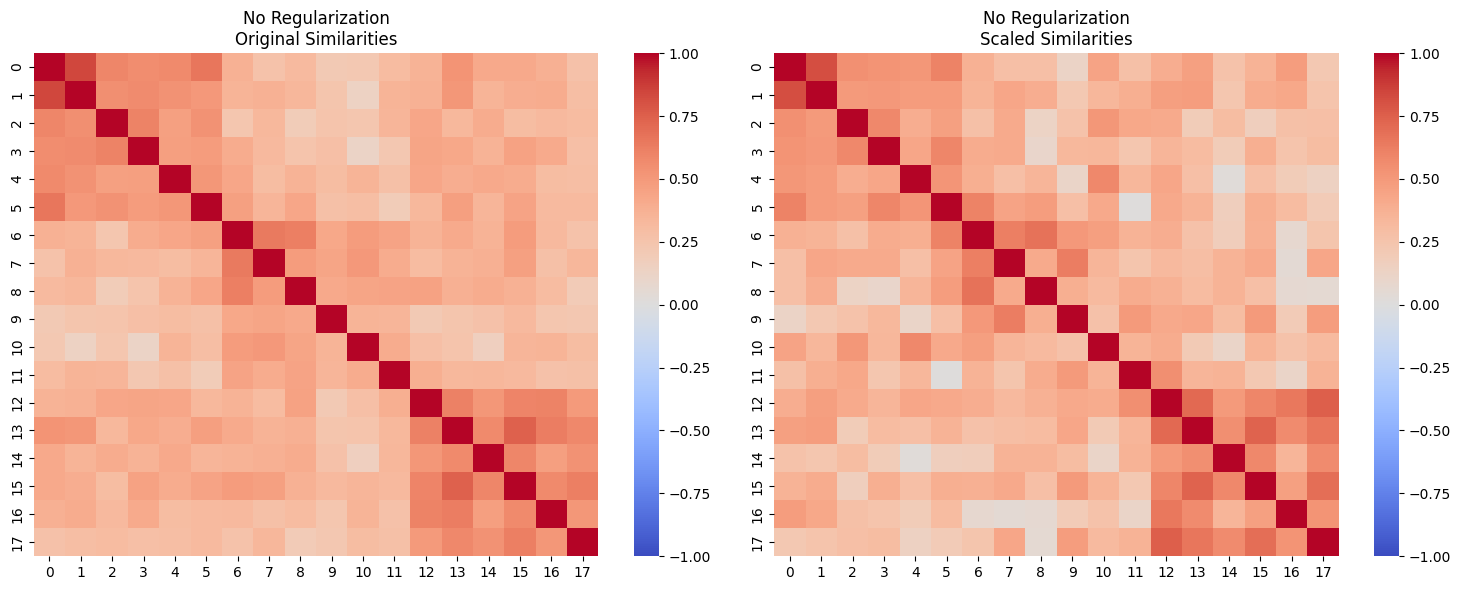


L2 Regularization Results:
Average ranking change: 2.60


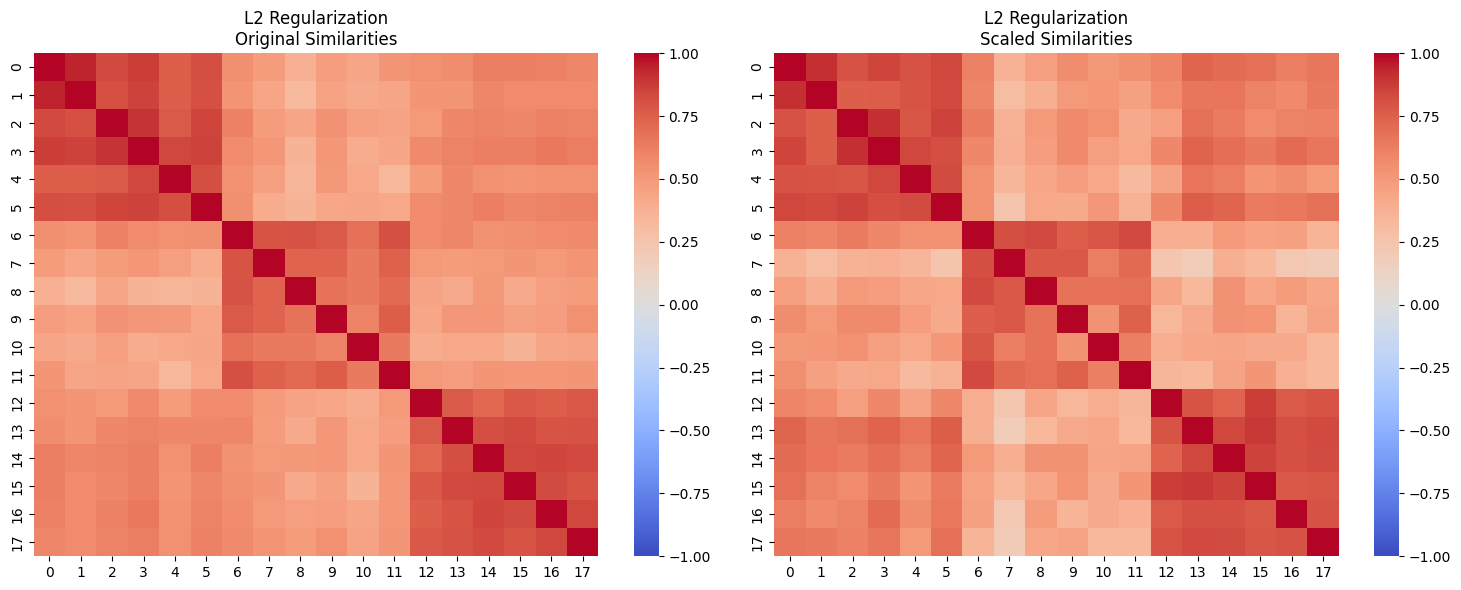

In [18]:
# Step 1: Create more structured test data with clear semantic relationships
sentences = [
    # Animal group
    "The cat chases the mouse",
    "The dog chases the cat",
    "The lion hunts the gazelle",
    "The wolf hunts the deer",
    "The tiger stalks its prey",
    "The fox catches the rabbit",
    # Nature group
    "The tree sways in the wind",
    "The flower blooms in spring",
    "The grass grows in sunlight",
    "The river flows downstream",
    "The leaves rustle gently",
    "The rain falls softly",
    # Human group
    "The teacher writes on board",
    "The student reads the book",
    "The worker builds the house",
    "The chef cooks the meal",
    "The artist paints the canvas",
    "The doctor helps patients"
]

# Assign group labels (0: Animal, 1: Nature, 2: Human)
groups = [0] * 6 + [1] * 6 + [2] * 6

# Add these at the beginning of your notebook, right after the imports
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call this before training
set_seeds()

class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
    def forward(self, x, normalize_output=False):
        # Get embeddings
        embedded = self.embedding(x)
        
        # Create mask for padding
        mask = (x != 0).float().unsqueeze(-1)
        
        # Apply mask and average
        summed = (embedded * mask).sum(dim=1)
        lengths = mask.sum(dim=1)
        lengths[lengths == 0] = 1
        averaged = summed / lengths
        
        if normalize_output:
            # L2 normalize the output embeddings
            norms = torch.norm(averaged, p=2, dim=1, keepdim=True)
            averaged = averaged / norms
                
        return averaged

def prepare_data(sentences):
    # Create vocabulary
    words = set()
    for sentence in sentences:
        words.update(sentence.lower().split())
    vocab = {word: idx+1 for idx, word in enumerate(sorted(words))}
        
    # Encode sentences
    encoded = []
    for sentence in sentences:
        encoded.append([vocab[word.lower()] for word in sentence.split()])
        
    return vocab, encoded

def train_model(encoded_sentences, model_params):
    """
    Train model with different regularization schemes
    """
    vocab_size = max(max(sent) for sent in encoded_sentences) + 1
    model = EmbeddingModel(vocab_size, model_params['embedding_dim'])
        
    # Convert data to tensors
    data = [torch.tensor(sent, dtype=torch.long) for sent in encoded_sentences]
        
    # Setup optimizer with specified regularization
    if model_params['regularization'] == 'l2':
        optimizer = optim.Adam(model.parameters(), 
                             lr=model_params['lr'],
                             weight_decay=model_params['weight_decay'])
    else:
        optimizer = optim.Adam(model.parameters(), 
                             lr=model_params['lr'])
        
    # Training loop
    for epoch in range(model_params['epochs']):
        total_loss = 0
        for i, anchor in enumerate(data):
            # Get positive examples (same group) and negative examples
            pos_indices = [j for j, g in enumerate(groups) if g == groups[i] and j != i]
            neg_indices = [j for j, g in enumerate(groups) if g != groups[i]]
                
            # Get embeddings
            anchor_emb = model(anchor.unsqueeze(0))  # Shape: (1, embedding_dim)
            
            # Positive embeddings
            pos_emb_list = [model(data[j].unsqueeze(0)) for j in pos_indices]
            if pos_emb_list:
                pos_emb = torch.cat(pos_emb_list, dim=0)  # Shape: (num_pos, embedding_dim)
            else:
                continue  # Skip if no positive examples
                
            # Negative embeddings
            neg_emb_list = [model(data[j].unsqueeze(0)) for j in neg_indices]
            if neg_emb_list:
                neg_emb = torch.cat(neg_emb_list, dim=0)  # Shape: (num_neg, embedding_dim)
            else:
                continue  # Skip if no negative examples
                
            # Compute similarities
            pos_sim = torch.mm(anchor_emb, pos_emb.t())  # Shape: (1, num_pos)
            neg_sim = torch.mm(anchor_emb, neg_emb.t())  # Shape: (1, num_neg)
                
            # Triplet loss
            # Adjust shapes to compute pairwise differences
            loss = torch.mean(torch.relu(neg_sim.t() - pos_sim + model_params['margin']))
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
    return model

def analyze_similarities(model, encoded_sentences, scaling_factor=100):
    """
    Analyze similarities with different scaling approaches
    """
    with torch.no_grad():
        # Get original embeddings
        embeddings = []
        for sent in encoded_sentences:
            emb = model(torch.tensor(sent).unsqueeze(0))
            embeddings.append(emb[0].numpy())
        embeddings = np.array(embeddings)
            
        # Calculate original similarities
        original_sim = cosine_similarity(embeddings)
            
        # Apply scaling to different dimensions
        dim = embeddings.shape[1]
        scaling = np.ones(dim)
        scaling[:dim//2] = 1/scaling_factor
        scaling[dim//2:] = scaling_factor
            
        scaled_embeddings = embeddings * scaling
        scaled_sim = cosine_similarity(scaled_embeddings)
            
        return original_sim, scaled_sim

def visualize_results(original_sim, scaled_sim, title_prefix=""):
    """
    Create side-by-side visualization of similarity matrices
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
    # Plot original similarities
    sns.heatmap(original_sim, ax=ax1, cmap='coolwarm', vmin=-1, vmax=1)
    ax1.set_title(f"{title_prefix}\nOriginal Similarities")
        
    # Plot scaled similarities
    sns.heatmap(scaled_sim, ax=ax2, cmap='coolwarm', vmin=-1, vmax=1)
    ax2.set_title(f"{title_prefix}\nScaled Similarities")
        
    plt.tight_layout()
    return fig

# Main execution
vocab, encoded_sentences = prepare_data(sentences)
    
# Train models with different regularization schemes
model_params = {
    'embedding_dim': 50,
    'lr': 0.001,
    'epochs': 100,  
    'margin': 0.5,
}
    
# No regularization
model_params['regularization'] = None
model_params['weight_decay'] = 0
no_reg_model = train_model(encoded_sentences, model_params)
    
# L2 regularization
model_params['regularization'] = 'l2'
model_params['weight_decay'] = 0.01
l2_reg_model = train_model(encoded_sentences, model_params)
    
# Analyze and visualize results
for model, name in [(no_reg_model, "No Regularization"), 
                    (l2_reg_model, "L2 Regularization")]:
    orig_sim, scaled_sim = analyze_similarities(model, encoded_sentences)
        
    # Calculate similarity preservation score
    ranking_changes = np.mean(np.abs(
        np.argsort(-orig_sim, axis=1) - 
        np.argsort(-scaled_sim, axis=1)
    ))
        
    print(f"\n{name} Results:")
    print(f"Average ranking change: {ranking_changes:.2f}")
        
    # Plot similarities
    fig = visualize_results(orig_sim, scaled_sim, name)
    plt.show()

In [19]:
# Add this function after all the existing code
def show_similarity_changes(sentences, original_sim, scaled_sim):
    # Look at the animal-related sentences (indices 0-5)
    animal_sentences = sentences[0:6]
    
    print("\nLet's look at how similar these animal-related sentences are to each other:")
    for sentence in animal_sentences:
        print(f"- {sentence}")
    print("\nBefore arbitrary scaling:")
    
    # Show original similarities between animal sentences
    for i, sent1 in enumerate(animal_sentences):
        print(f"\nFor '{sent1}':")
        # Get similarities to other animal sentences
        similarities = [(j, original_sim[i][j]) for j in range(6) if j != i]
        # Sort by similarity
        similarities.sort(key=lambda x: x[1], reverse=True)
        # Show top 3 most similar for readability
        for j, sim in similarities[:3]:
            print(f"- {sim:.2f} similar to '{animal_sentences[j]}'")
    
    print("\nAfter arbitrary scaling:")
    # Show scaled similarities between animal sentences
    for i, sent1 in enumerate(animal_sentences):
        print(f"\nFor '{sent1}':")
        # Get similarities to other animal sentences
        similarities = [(j, scaled_sim[i][j]) for j in range(6) if j != i]
        # Sort by similarity
        similarities.sort(key=lambda x: x[1], reverse=True)
        # Show top 3 most similar for readability
        for j, sim in similarities[:3]:
            print(f"- {sim:.2f} similar to '{animal_sentences[j]}'")
            
    # Also show examples of how similarities to unrelated sentences change
    print("\nLet's see how similarities to unrelated sentences change:")
    nature_sentence = sentences[6]  # First nature sentence
    human_sentence = sentences[12]  # First human sentence
    print(f"\nComparing 'The cat chases the mouse' to '{nature_sentence}':")
    print(f"Before scaling: {original_sim[0][6]:.2f} similarity")
    print(f"After scaling:  {scaled_sim[0][6]:.2f} similarity")
    print(f"\nComparing 'The cat chases the mouse' to '{human_sentence}':")
    print(f"Before scaling: {original_sim[0][12]:.2f} similarity")
    print(f"After scaling:  {scaled_sim[0][12]:.2f} similarity")

# Add these lines at the very end of your main execution code
# (after the visualization loop)
print("\n=== No Regularization Similarity Analysis ===")
no_reg_orig_sim, no_reg_scaled_sim = analyze_similarities(no_reg_model, encoded_sentences)
show_similarity_changes(sentences, no_reg_orig_sim, no_reg_scaled_sim)

print("\n=== L2 Regularization Similarity Analysis ===")
l2_orig_sim, l2_scaled_sim = analyze_similarities(l2_reg_model, encoded_sentences)
show_similarity_changes(sentences, l2_orig_sim, l2_scaled_sim)


=== No Regularization Similarity Analysis ===

Let's look at how similar these animal-related sentences are to each other:
- The cat chases the mouse
- The dog chases the cat
- The lion hunts the gazelle
- The wolf hunts the deer
- The tiger stalks its prey
- The fox catches the rabbit

Before arbitrary scaling:

For 'The cat chases the mouse':
- 0.84 similar to 'The dog chases the cat'
- 0.66 similar to 'The fox catches the rabbit'
- 0.59 similar to 'The lion hunts the gazelle'

For 'The dog chases the cat':
- 0.84 similar to 'The cat chases the mouse'
- 0.57 similar to 'The wolf hunts the deer'
- 0.55 similar to 'The lion hunts the gazelle'

For 'The lion hunts the gazelle':
- 0.60 similar to 'The wolf hunts the deer'
- 0.59 similar to 'The cat chases the mouse'
- 0.55 similar to 'The dog chases the cat'

For 'The wolf hunts the deer':
- 0.60 similar to 'The lion hunts the gazelle'
- 0.57 similar to 'The dog chases the cat'
- 0.55 similar to 'The cat chases the mouse'

For 'The tige

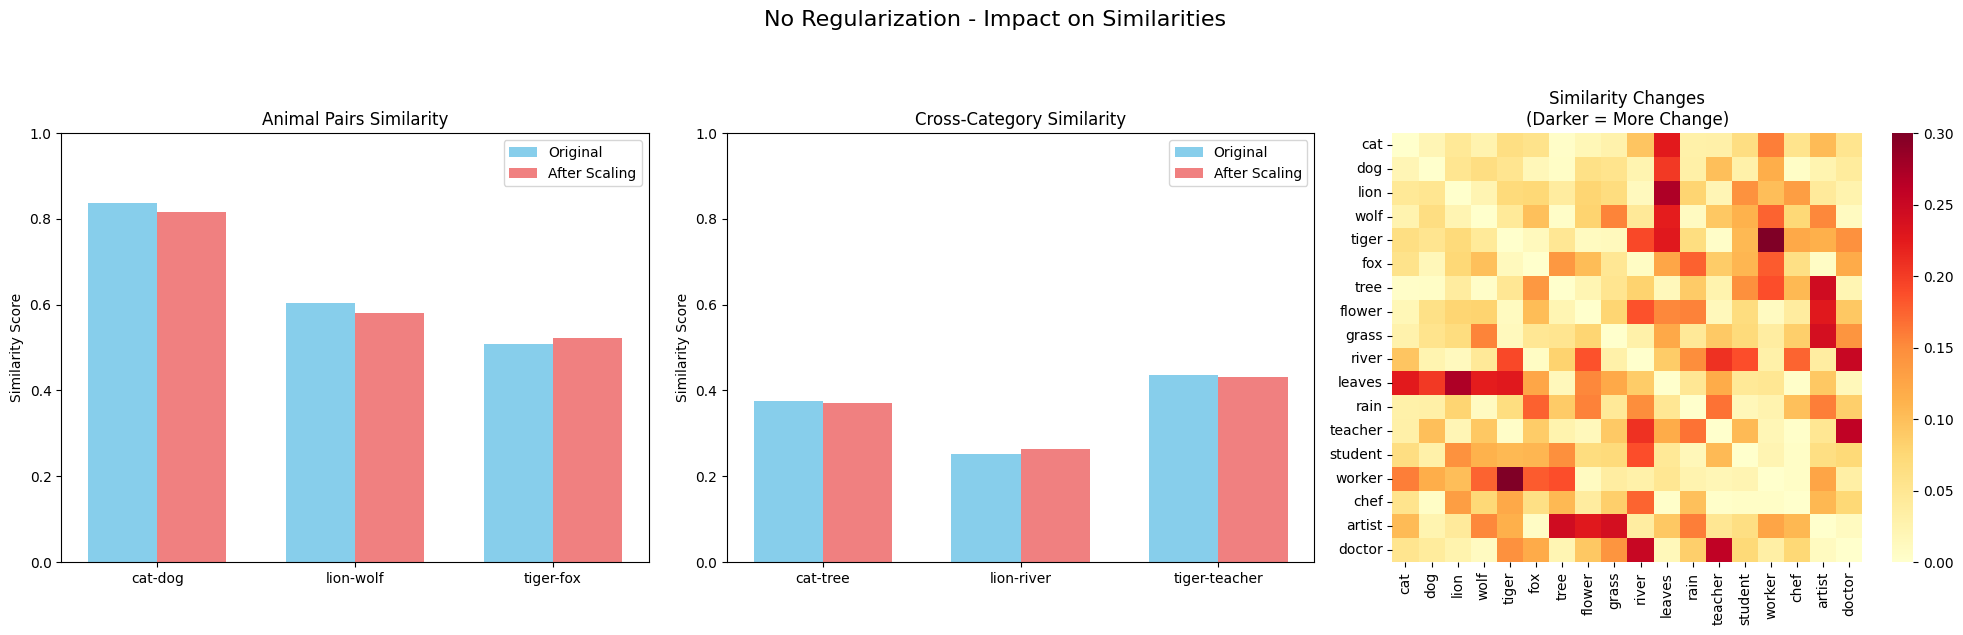


No Regularization Key Metrics:
Average similarity change: 0.080
Max similarity change: 0.390
--------------------------------------------------


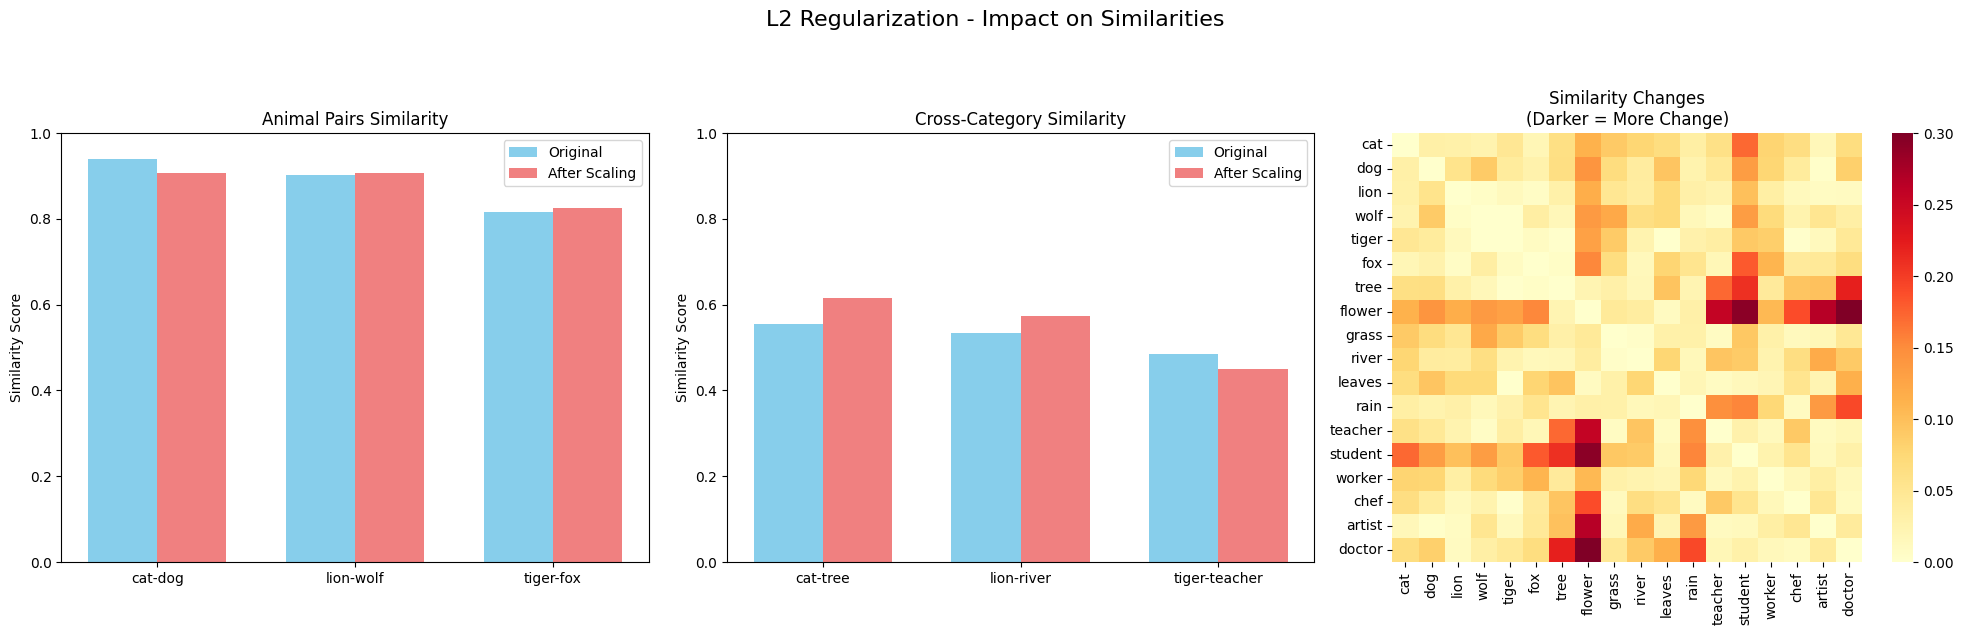


L2 Regularization Key Metrics:
Average similarity change: 0.060
Max similarity change: 0.327
--------------------------------------------------


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_similarity_changes(sentences, original_sim, scaled_sim, reg_type=""):
    # Create a figure with three subplots
    fig = plt.figure(figsize=(20, 6))
    
    # 1. Similarity Changes for Animal Group
    ax1 = plt.subplot(131)
    
    # Prepare data for animal group comparisons
    animal_pairs = [
        ("cat-dog", (0, 1)),
        ("lion-wolf", (2, 3)),
        ("tiger-fox", (4, 5))
    ]
    
    # Get similarities before and after scaling
    pair_names = []
    orig_sims = []
    scaled_sims = []
    for name, (i, j) in animal_pairs:
        pair_names.append(name)
        orig_sims.append(original_sim[i][j])
        scaled_sims.append(scaled_sim[i][j])
    
    # Plot paired bars
    x = np.arange(len(pair_names))
    width = 0.35
    ax1.bar(x - width/2, orig_sims, width, label='Original', color='skyblue')
    ax1.bar(x + width/2, scaled_sims, width, label='After Scaling', color='lightcoral')
    
    ax1.set_ylabel('Similarity Score')
    ax1.set_title('Animal Pairs Similarity')
    ax1.set_xticks(x)
    ax1.set_xticklabels(pair_names)
    ax1.legend()
    ax1.set_ylim(0, 1)
    
    # 2. Cross-Category Similarity Changes
    ax2 = plt.subplot(132)
    
    # Compare cat sentence to one from each category
    cross_pairs = [
        ("cat-tree", (0, 6)),
        ("lion-river", (2, 9)),
        ("tiger-teacher", (4, 12))
    ]
    
    # Get similarities
    cross_names = []
    cross_orig = []
    cross_scaled = []
    for name, (i, j) in cross_pairs:
        cross_names.append(name)
        cross_orig.append(original_sim[i][j])
        cross_scaled.append(scaled_sim[i][j])
    
    # Plot paired bars
    x = np.arange(len(cross_names))
    ax2.bar(x - width/2, cross_orig, width, label='Original', color='skyblue')
    ax2.bar(x + width/2, cross_scaled, width, label='After Scaling', color='lightcoral')
    
    ax2.set_ylabel('Similarity Score')
    ax2.set_title('Cross-Category Similarity')
    ax2.set_xticks(x)
    ax2.set_xticklabels(cross_names)
    ax2.legend()
    ax2.set_ylim(0, 1)
    
    # 3. Stability Heatmap
    ax3 = plt.subplot(133)
    
    # Calculate absolute changes in similarity
    similarity_changes = np.abs(scaled_sim - original_sim)
    
    # Create heatmap of changes with fixed vmin and vmax
    sns.heatmap(similarity_changes, 
                ax=ax3,
                cmap='YlOrRd',
                vmin=0,
                vmax=0.3,
                xticklabels=[s.split()[1] for s in sentences],
                yticklabels=[s.split()[1] for s in sentences])
    ax3.set_title('Similarity Changes\n(Darker = More Change)')
    
    plt.suptitle(f'{reg_type} - Impact on Similarities', fontsize=16, y=1.05)
    plt.tight_layout()
    return fig

# Run visualization for each regularization type
for model_name, orig_sim, scaled_sim in [
    ("No Regularization", no_reg_orig_sim, no_reg_scaled_sim),
    ("L2 Regularization", l2_orig_sim, l2_scaled_sim)
]:
    fig = visualize_similarity_changes(sentences, orig_sim, scaled_sim, model_name)
    plt.show()
    
    # Print some key metrics
    print(f"\n{model_name} Key Metrics:")
    print(f"Average similarity change: {np.mean(np.abs(scaled_sim - orig_sim)):.3f}")
    print(f"Max similarity change: {np.max(np.abs(scaled_sim - orig_sim)):.3f}")
    print("-" * 50)


No Regularization Summary:
Group Coherence Changes:
  Animal: -0.033
  Nature: -0.025
  Human: 0.017
Average Ranking Preservation: 0.648
Max Absolute Change: 0.390


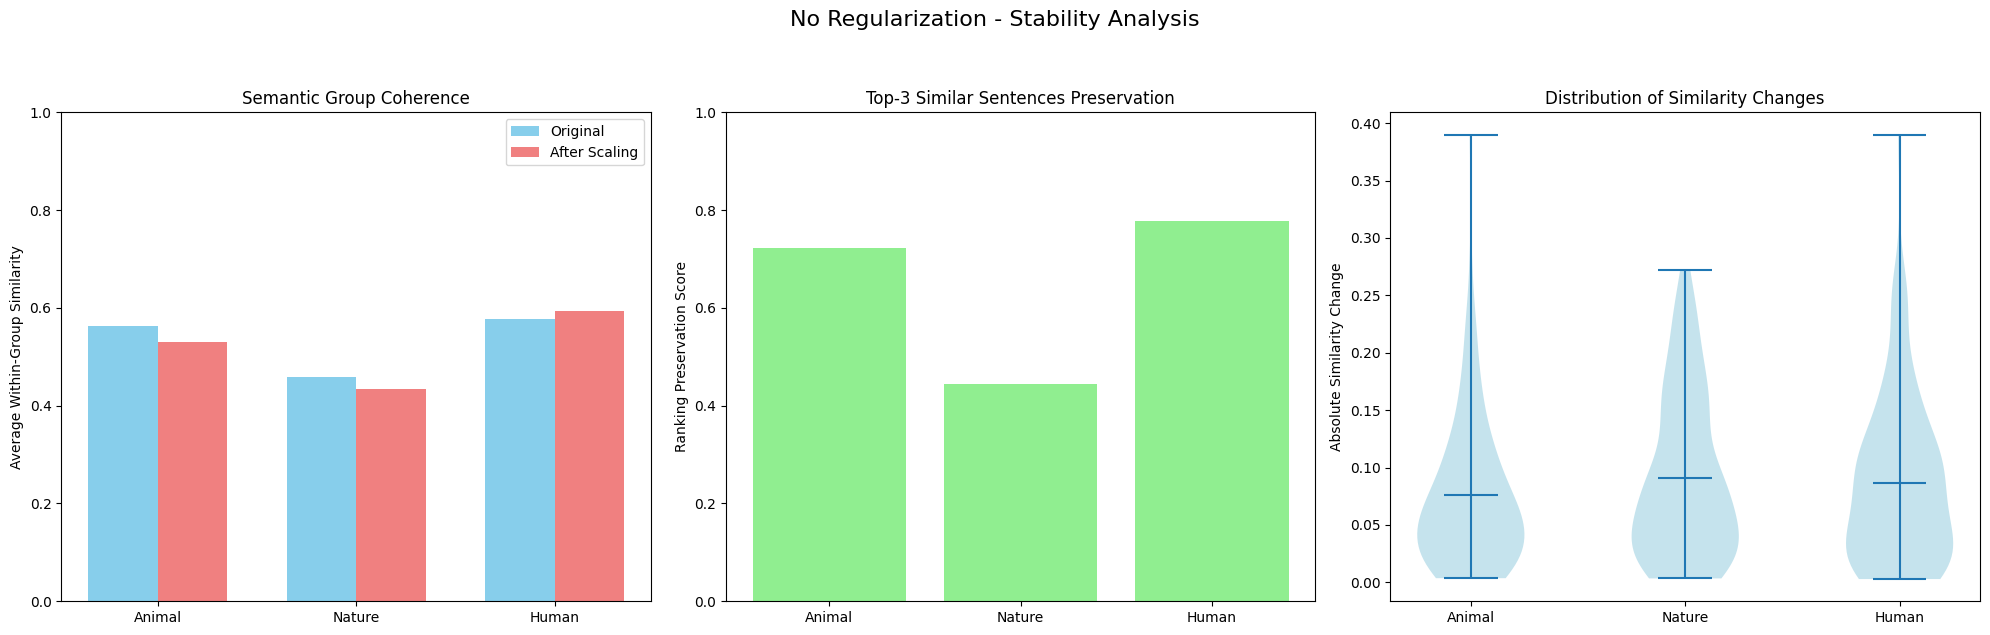


L2 Regularization Summary:
Group Coherence Changes:
  Animal: -0.000
  Nature: -0.004
  Human: 0.010
Average Ranking Preservation: 0.704
Max Absolute Change: 0.266


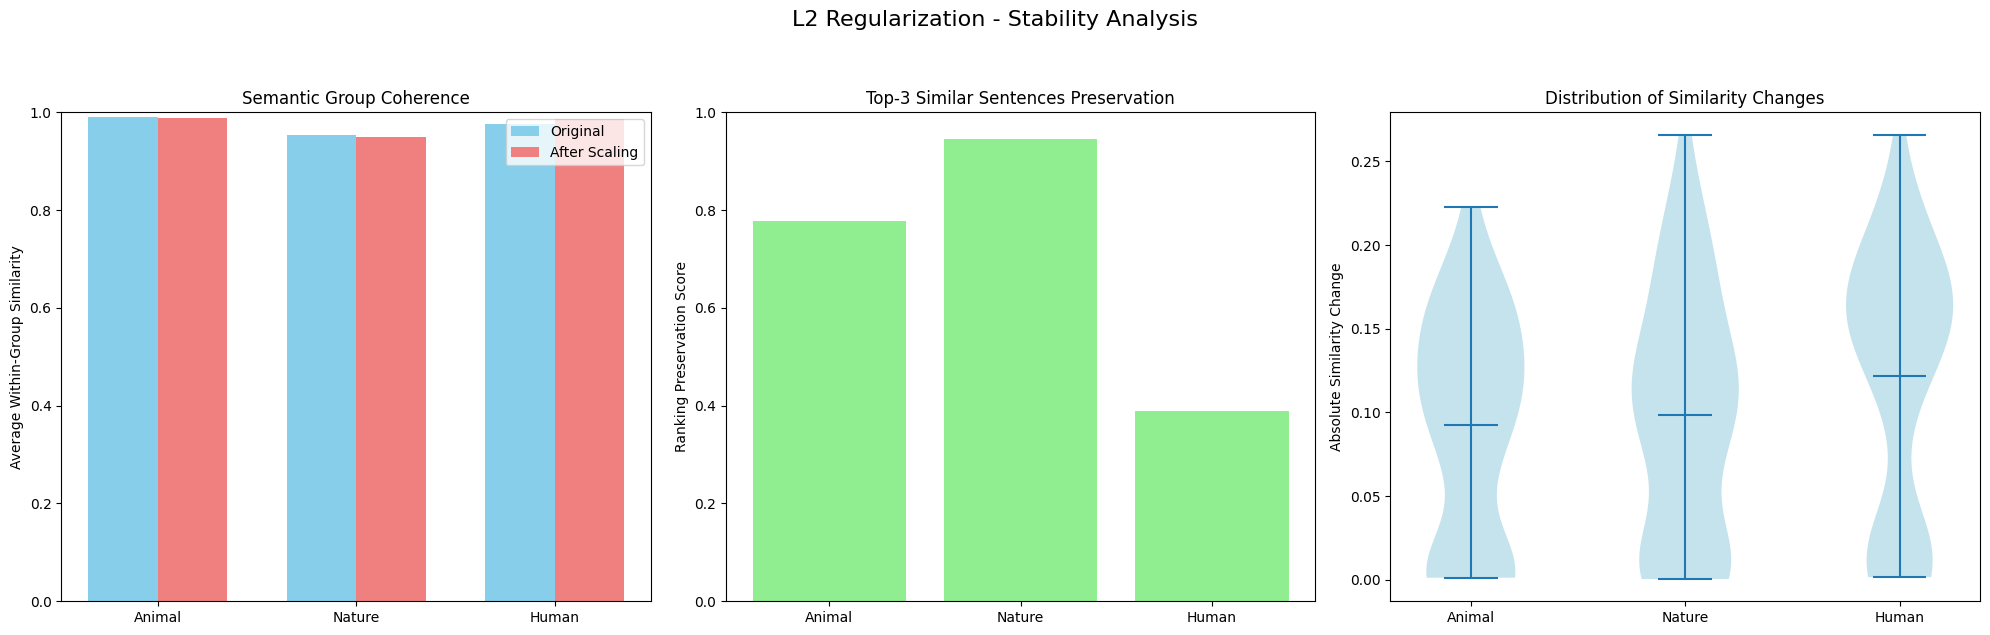

In [17]:
def analyze_similarities_stable(sentences, original_sim, scaled_sim, reg_type=""):
    """
    More stable version of similarity analysis that focuses on relative changes
    and meaningful semantic relationships
    """
    fig = plt.figure(figsize=(20, 6))
    
    # 1. Semantic Group Coherence (left plot)
    ax1 = plt.subplot(131)
    
    # Group sentences by category
    groups = {
        'Animal': (0, 6),   # indices 0-5
        'Nature': (6, 12),  # indices 6-11
        'Human': (12, 18)   # indices 12-17
    }
    
    # Calculate average within-group similarity before and after scaling
    group_scores = []
    for group_name, (start, end) in groups.items():
        # Get within-group similarities
        orig_group_sim = []
        scaled_group_sim = []
        for i in range(start, end):
            for j in range(i+1, end):
                orig_group_sim.append(original_sim[i][j])
                scaled_group_sim.append(scaled_sim[i][j])
        
        group_scores.append({
            'name': group_name,
            'original': np.mean(orig_group_sim),
            'scaled': np.mean(scaled_group_sim),
            'change': np.mean(scaled_group_sim) - np.mean(orig_group_sim)
        })
    
    # Plot group coherence
    x = np.arange(len(groups))
    width = 0.35
    ax1.bar(x - width/2, [s['original'] for s in group_scores], width, 
            label='Original', color='skyblue')
    ax1.bar(x + width/2, [s['scaled'] for s in group_scores], width,
            label='After Scaling', color='lightcoral')
    
    ax1.set_ylabel('Average Within-Group Similarity')
    ax1.set_title('Semantic Group Coherence')
    ax1.set_xticks(x)
    ax1.set_xticklabels([s['name'] for s in group_scores])
    ax1.legend()
    ax1.set_ylim(0, 1)
    
    # 2. Relative Similarity Preservation (middle plot)
    ax2 = plt.subplot(132)
    
    # Calculate how well relative similarities are preserved
    def get_relative_rankings(sim_matrix, start, end):
        rankings = []
        for i in range(start, end):
            # Get similarities to all other sentences
            sims = [(j, sim_matrix[i][j]) for j in range(len(sentences)) if j != i]
            # Sort by similarity
            sims.sort(key=lambda x: x[1], reverse=True)
            rankings.append([j for j, _ in sims])
        return rankings
    
    # Compare top-3 most similar sentences before and after scaling
    preservation_scores = []
    for group_name, (start, end) in groups.items():
        orig_rankings = get_relative_rankings(original_sim, start, end)
        scaled_rankings = get_relative_rankings(scaled_sim, start, end)
        
        # Calculate ranking preservation score
        preservation = 0
        for orig, scaled in zip(orig_rankings, scaled_rankings):
            # Check overlap in top 3
            orig_top3 = set(orig[:3])
            scaled_top3 = set(scaled[:3])
            preservation += len(orig_top3.intersection(scaled_top3)) / 3
            
        preservation_scores.append(preservation / (end - start))
    
    # Plot preservation scores
    ax2.bar(groups.keys(), preservation_scores, color='lightgreen')
    ax2.set_ylabel('Ranking Preservation Score')
    ax2.set_title('Top-3 Similar Sentences Preservation')
    ax2.set_ylim(0, 1)
    
    # 3. Similarity Change Distribution (right plot)
    ax3 = plt.subplot(133)
    
    # Calculate similarity changes
    changes = scaled_sim - original_sim
    
    # Create violin plot for each group
    violin_data = []
    violin_labels = []
    for group_name, (start, end) in groups.items():
        group_changes = []
        for i in range(start, end):
            for j in range(len(sentences)):
                if i != j:
                    group_changes.append(abs(changes[i][j]))
        violin_data.append(group_changes)
        violin_labels.append(group_name)
    
    vp = ax3.violinplot(violin_data, showmeans=True)
    ax3.set_xticks(np.arange(1, len(groups) + 1))
    ax3.set_xticklabels(violin_labels)
    ax3.set_ylabel('Absolute Similarity Change')
    ax3.set_title('Distribution of Similarity Changes')
    
    # Customize violin plot colors
    for pc in vp['bodies']:
        pc.set_facecolor('lightblue')
        pc.set_alpha(0.7)
    
    plt.suptitle(f'{reg_type} - Stability Analysis', fontsize=16, y=1.05)
    plt.tight_layout()
    
    # Print summary statistics
    print(f"\n{reg_type} Summary:")
    print("Group Coherence Changes:")
    for score in group_scores:
        print(f"  {score['name']}: {score['change']:.3f}")
    print(f"Average Ranking Preservation: {np.mean(preservation_scores):.3f}")
    print(f"Max Absolute Change: {np.max(np.abs(changes)):.3f}")
    
    return fig

# Run the analysis for each regularization type
for model_name, orig_sim, scaled_sim in [
    ("No Regularization", no_reg_orig_sim, no_reg_scaled_sim),
    ("L2 Regularization", l2_orig_sim, l2_scaled_sim)
]:
    fig = analyze_similarities_stable(sentences, orig_sim, scaled_sim, model_name)
    plt.show()

# Spherical Method


=== No Regularization Results ===
Average similarity change: 0.07979530339490395
Max similarity change: 0.39007009434878537

=== Spherical Normalization Results ===
Semantic Coherence by Group:
Animal group: 0.624
Nature group: 0.528
Human group: 0.590


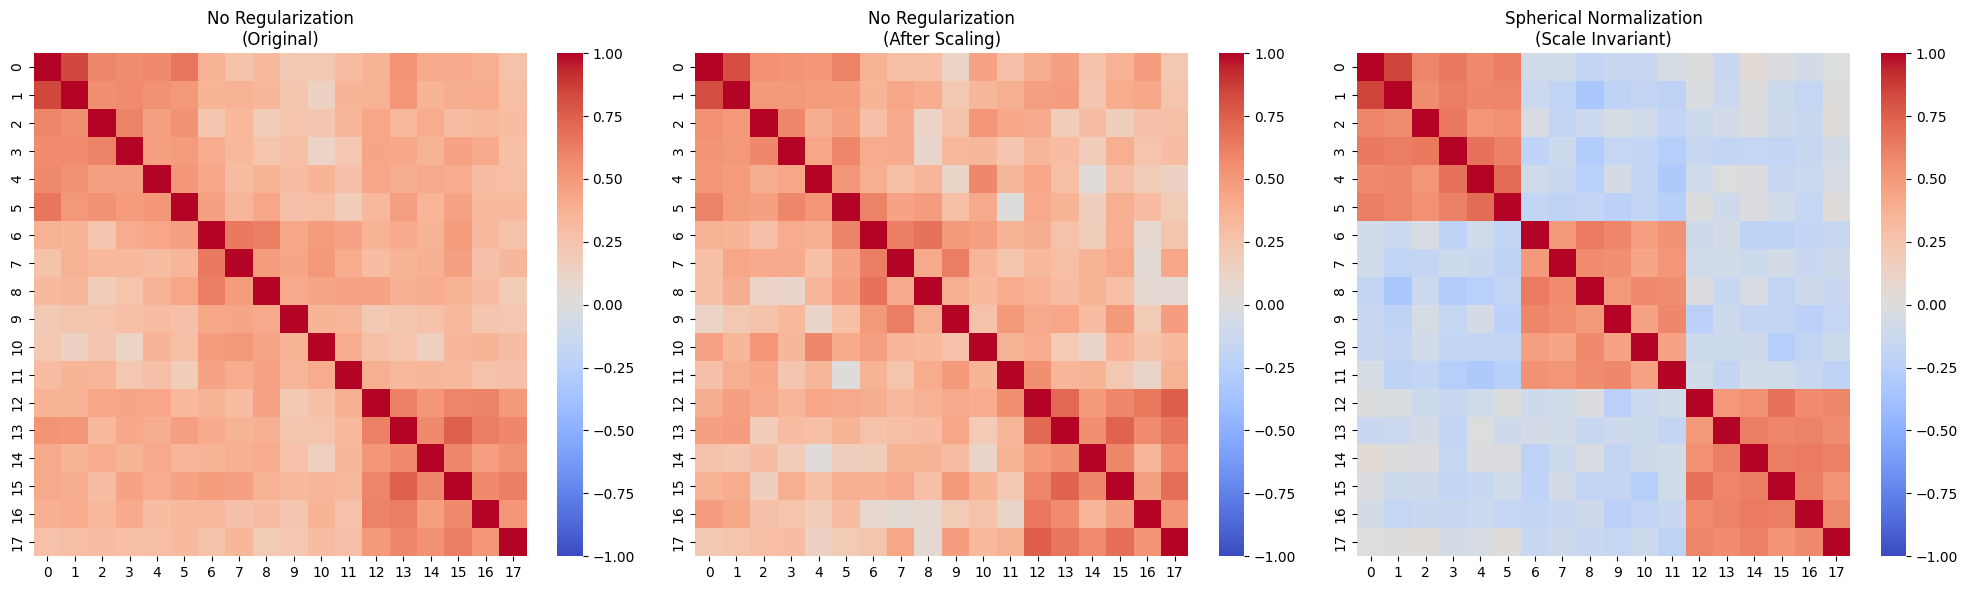


=== Detailed Comparison ===

No Regularization (Original):
Animal_internal: 0.564
Animal_external: 0.299
Nature_internal: 0.458
Nature_external: nan
Human_internal: 0.577
Human_external: 0.380

Spherical Normalization:
Animal_internal: 0.624
Animal_external: -0.170
Nature_internal: 0.528
Nature_external: nan
Human_internal: 0.590
Human_external: -0.078


/var/folders/py/19s8w1_s0_g5bw1c_0qmm1s80000gn/T/ipykernel_42360/4288751432.py:274: RuntimeWarning: Mean of empty slice.
  metrics[f'{name}_external'] = between_sim.mean()
/Users/eli/code/cosine_sim_analysis/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [28]:
# Step 1: Create structured test data with semantic groups
sentences = [
    # Animal group
    "The cat chases the mouse",
    "The dog chases the cat",
    "The lion hunts the gazelle", 
    "The wolf hunts the deer",
    "The tiger stalks its prey",
    "The fox catches the rabbit",
    # Nature group
    "The tree sways in the wind",
    "The flower blooms in spring", 
    "The grass grows in sunlight",
    "The river flows downstream",
    "The leaves rustle gently",
    "The rain falls softly",
    # Human group
    "The teacher writes on board",
    "The student reads the book",
    "The worker builds the house",
    "The chef cooks the meal", 
    "The artist paints the canvas",
    "The doctor helps patients"
]

# Assign group labels (0: Animal, 1: Nature, 2: Human)
groups = [0] * 6 + [1] * 6 + [2] * 6

def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set random seeds for reproducibility
set_seeds()

class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
    def forward(self, x, normalize_output=False):
        # Get embeddings
        embedded = self.embedding(x)
        
        # Create mask for padding tokens
        mask = (x != 0).float().unsqueeze(-1)
        
        # Apply mask and compute mean embedding
        summed = (embedded * mask).sum(dim=1)
        lengths = mask.sum(dim=1)
        lengths[lengths == 0] = 1  # Avoid division by zero
        averaged = summed / lengths
        
        if normalize_output:
            # L2 normalize if requested
            norms = torch.norm(averaged, p=2, dim=1, keepdim=True)
            averaged = averaged / norms
                
        return averaged

class SphericalEmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
    def forward(self, x):
        # Get embeddings
        embedded = self.embedding(x)
        
        # Create mask for padding tokens
        mask = (x != 0).float().unsqueeze(-1)
        
        # Apply mask and compute mean embedding
        summed = (embedded * mask).sum(dim=1)
        lengths = mask.sum(dim=1)
        lengths[lengths == 0] = 1  # Avoid division by zero
        averaged = summed / lengths
        
        # Project onto unit sphere
        normalized = F.normalize(averaged, p=2, dim=1)
        return normalized
    
    def get_normalized_embedding_matrix(self):
        # Project embedding matrix onto unit sphere
        return F.normalize(self.embedding.weight, p=2, dim=1)

def prepare_data(sentences):
    # Build vocabulary from sentences
    words = set()
    for sentence in sentences:
        words.update(sentence.lower().split())
    vocab = {word: idx+1 for idx, word in enumerate(sorted(words))}
        
    # Convert sentences to token indices
    encoded = []
    for sentence in sentences:
        encoded.append([vocab[word.lower()] for word in sentence.split()])
        
    return vocab, encoded

def train_model(encoded_sentences, model_params):
    """
    Train embedding model with optional L2 regularization
    """
    vocab_size = max(max(sent) for sent in encoded_sentences) + 1
    model = EmbeddingModel(vocab_size, model_params['embedding_dim'])
        
    # Convert sentences to tensors
    data = [torch.tensor(sent, dtype=torch.long) for sent in encoded_sentences]
        
    # Configure optimizer with optional L2 regularization
    if model_params.get('regularization') == 'l2':
        optimizer = optim.Adam(model.parameters(), 
                             lr=model_params['lr'],
                             weight_decay=model_params['weight_decay'])
    else:
        optimizer = optim.Adam(model.parameters(), 
                             lr=model_params['lr'])
        
    # Training loop with triplet loss
    for epoch in range(model_params['epochs']):
        total_loss = 0
        for i, anchor in enumerate(data):
            # Sample positive examples (same group) and negative examples (different groups)
            pos_indices = [j for j, g in enumerate(groups) if g == groups[i] and j != i]
            neg_indices = [j for j, g in enumerate(groups) if g != groups[i]]
                
            # Get anchor embedding
            anchor_emb = model(anchor.unsqueeze(0))
            
            # Get positive embeddings
            pos_emb_list = [model(data[j].unsqueeze(0)) for j in pos_indices]
            if pos_emb_list:
                pos_emb = torch.cat(pos_emb_list, dim=0)
            else:
                continue
                
            # Get negative embeddings
            neg_emb_list = [model(data[j].unsqueeze(0)) for j in neg_indices]
            if neg_emb_list:
                neg_emb = torch.cat(neg_emb_list, dim=0)
            else:
                continue
                
            # Compute similarities
            pos_sim = torch.mm(anchor_emb, pos_emb.t())
            neg_sim = torch.mm(anchor_emb, neg_emb.t())
                
            # Compute triplet loss
            loss = torch.mean(torch.relu(neg_sim.t() - pos_sim + model_params['margin']))
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
    return model

def train_spherical_model(encoded_sentences, model_params):
    """
    Train embedding model with spherical normalization
    """
    vocab_size = max(max(sent) for sent in encoded_sentences) + 1
    model = SphericalEmbeddingModel(vocab_size, model_params['embedding_dim'])
    
    # Convert sentences to tensors
    data = [torch.tensor(sent, dtype=torch.long) for sent in encoded_sentences]
    
    optimizer = optim.Adam(model.parameters(), lr=model_params['lr'])
    
    # Training loop with triplet loss
    for epoch in range(model_params['epochs']):
        total_loss = 0
        for i, anchor in enumerate(data):
            # Sample positive examples (same group) and negative examples (different groups)
            pos_indices = [j for j, g in enumerate(groups) if g == groups[i] and j != i]
            neg_indices = [j for j, g in enumerate(groups) if g != groups[i]]
            
            # Get normalized embeddings
            anchor_emb = model(anchor.unsqueeze(0))
            
            # Get positive embeddings
            pos_emb_list = [model(data[j].unsqueeze(0)) for j in pos_indices]
            if pos_emb_list:
                pos_emb = torch.cat(pos_emb_list, dim=0)
            else:
                continue
            
            # Get negative embeddings
            neg_emb_list = [model(data[j].unsqueeze(0)) for j in neg_indices]
            if neg_emb_list:
                neg_emb = torch.cat(neg_emb_list, dim=0)
            else:
                continue
            
            # Compute cosine similarities (dot product of normalized vectors)
            pos_sim = torch.mm(anchor_emb, pos_emb.t())
            neg_sim = torch.mm(anchor_emb, neg_emb.t())
            
            # Compute triplet loss
            loss = torch.mean(torch.relu(neg_sim.t() - pos_sim + model_params['margin']))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
    return model

def analyze_similarities(model, encoded_sentences, scaling_factor=100):
    """
    Analyze embedding similarities before and after dimension scaling
    """
    with torch.no_grad():
        # Get original embeddings
        embeddings = []
        for sent in encoded_sentences:
            emb = model(torch.tensor(sent).unsqueeze(0))
            embeddings.append(emb[0].numpy())
        embeddings = np.array(embeddings)
            
        # Calculate original cosine similarities
        original_sim = cosine_similarity(embeddings)
            
        # Scale first half of dimensions down and second half up
        dim = embeddings.shape[1]
        scaling = np.ones(dim)
        scaling[:dim//2] = 1/scaling_factor
        scaling[dim//2:] = scaling_factor
            
        scaled_embeddings = embeddings * scaling
        scaled_sim = cosine_similarity(scaled_embeddings)
            
        return original_sim, scaled_sim

def analyze_spherical_similarities(model, encoded_sentences):
    """
    Analyze similarities for spherical embeddings
    """
    with torch.no_grad():
        # Get normalized embeddings
        embeddings = []
        for sent in encoded_sentences:
            emb = model(torch.tensor(sent).unsqueeze(0))
            embeddings.append(emb[0].numpy())
        embeddings = np.array(embeddings)
        
        # Compute cosine similarities
        similarities = np.dot(embeddings, embeddings.T)
        
        return similarities

def compute_group_metrics(similarities):
    """
    Compute within-group and between-group similarity metrics
    """
    metrics = {}
    for group_id, name in enumerate(['Animal', 'Nature', 'Human']):
        start_idx = group_id * 6
        end_idx = start_idx + 6
        
        # Calculate within-group similarity
        group_sim = similarities[start_idx:end_idx, start_idx:end_idx]
        mask = ~np.eye(group_sim.shape[0], dtype=bool)
        metrics[f'{name}_internal'] = group_sim[mask].mean()
        
        # Calculate between-group similarity with next group
        next_start = (group_id + 1) * 6 % 18
        next_end = (group_id + 2) * 6 % 18
        between_sim = similarities[start_idx:end_idx, next_start:next_end]
        metrics[f'{name}_external'] = between_sim.mean()
    
    return metrics

# Main execution
vocab, encoded_sentences = prepare_data(sentences)

# Model hyperparameters
model_params = {
    'embedding_dim': 50,
    'lr': 0.001,
    'epochs': 500,
    'margin': 0.5,
}

# Train baseline model without regularization
no_reg_model = train_model(encoded_sentences, model_params)
no_reg_orig_sim, no_reg_scaled_sim = analyze_similarities(no_reg_model, encoded_sentences)

# Train spherical model
spherical_model = train_spherical_model(encoded_sentences, model_params)
spherical_sim = analyze_spherical_similarities(spherical_model, encoded_sentences)

# Print baseline model results
print("\n=== No Regularization Results ===")
print("Average similarity change:", np.mean(np.abs(no_reg_scaled_sim - no_reg_orig_sim)))
print("Max similarity change:", np.max(np.abs(no_reg_scaled_sim - no_reg_orig_sim)))

# Print spherical model results
print("\n=== Spherical Normalization Results ===")
print("Semantic Coherence by Group:")
for group_id, name in enumerate(['Animal', 'Nature', 'Human']):
    start_idx = group_id * 6
    end_idx = start_idx + 6
    group_similarities = spherical_sim[start_idx:end_idx, start_idx:end_idx]
    mask = ~np.eye(group_similarities.shape[0], dtype=bool)
    avg_similarity = group_similarities[mask].mean()
    print(f"{name} group: {avg_similarity:.3f}")

# Visualize similarity matrices
plt.figure(figsize=(20, 6))

plt.subplot(131)
sns.heatmap(no_reg_orig_sim, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("No Regularization\n(Original)")

plt.subplot(132)
sns.heatmap(no_reg_scaled_sim, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("No Regularization\n(After Scaling)")

plt.subplot(133)
sns.heatmap(spherical_sim, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spherical Normalization\n(Scale Invariant)")

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\n=== Detailed Comparison ===")
print("\nNo Regularization (Original):")
no_reg_metrics = compute_group_metrics(no_reg_orig_sim)
for k, v in no_reg_metrics.items():
    print(f"{k}: {v:.3f}")

print("\nSpherical Normalization:")
spherical_metrics = compute_group_metrics(spherical_sim)
for k, v in spherical_metrics.items():
    print(f"{k}: {v:.3f}")

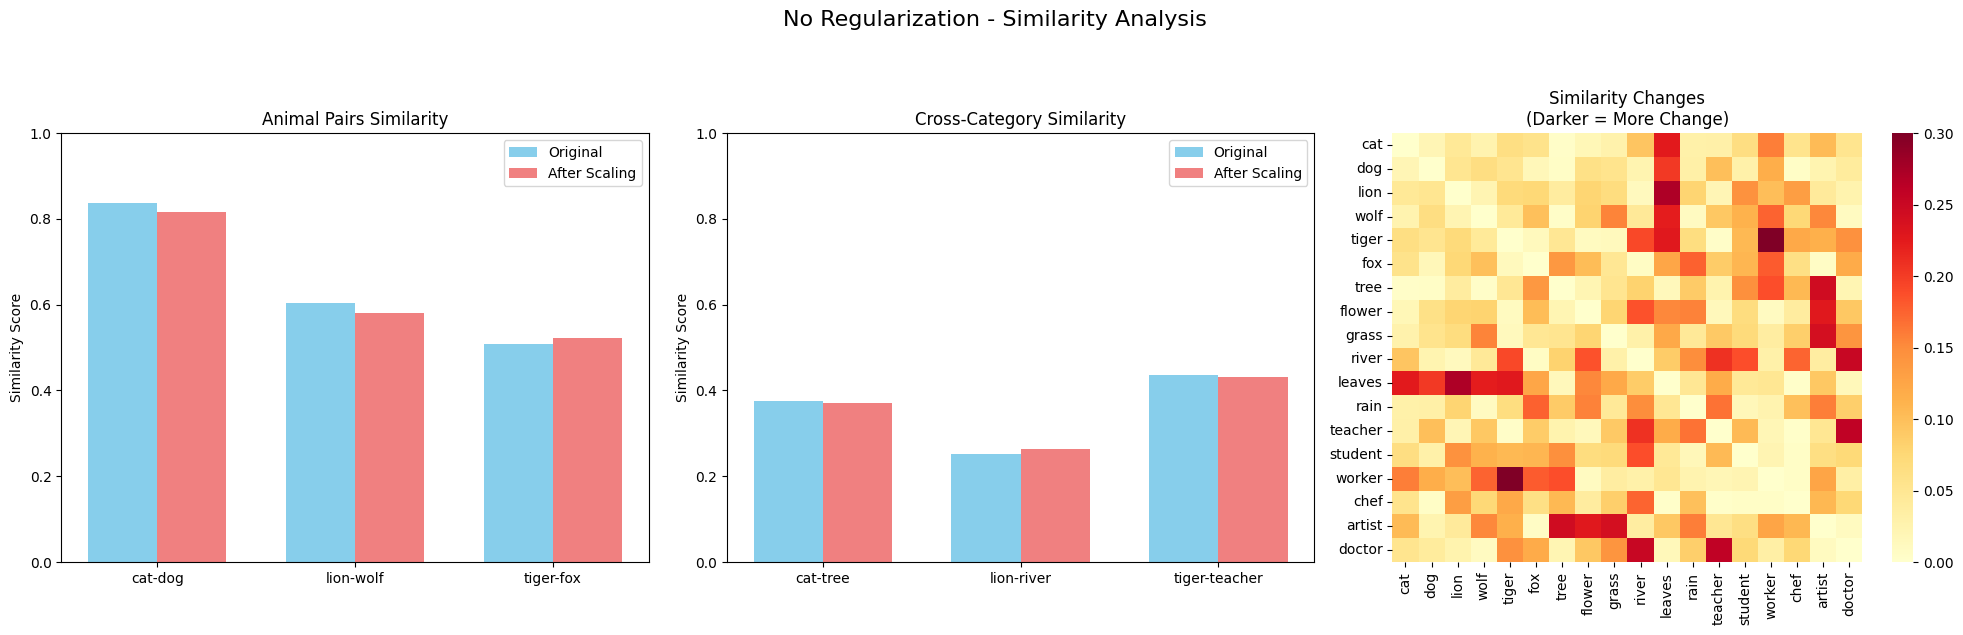


No Regularization Key Metrics:
Average similarity change: 0.080
Max similarity change: 0.390
--------------------------------------------------


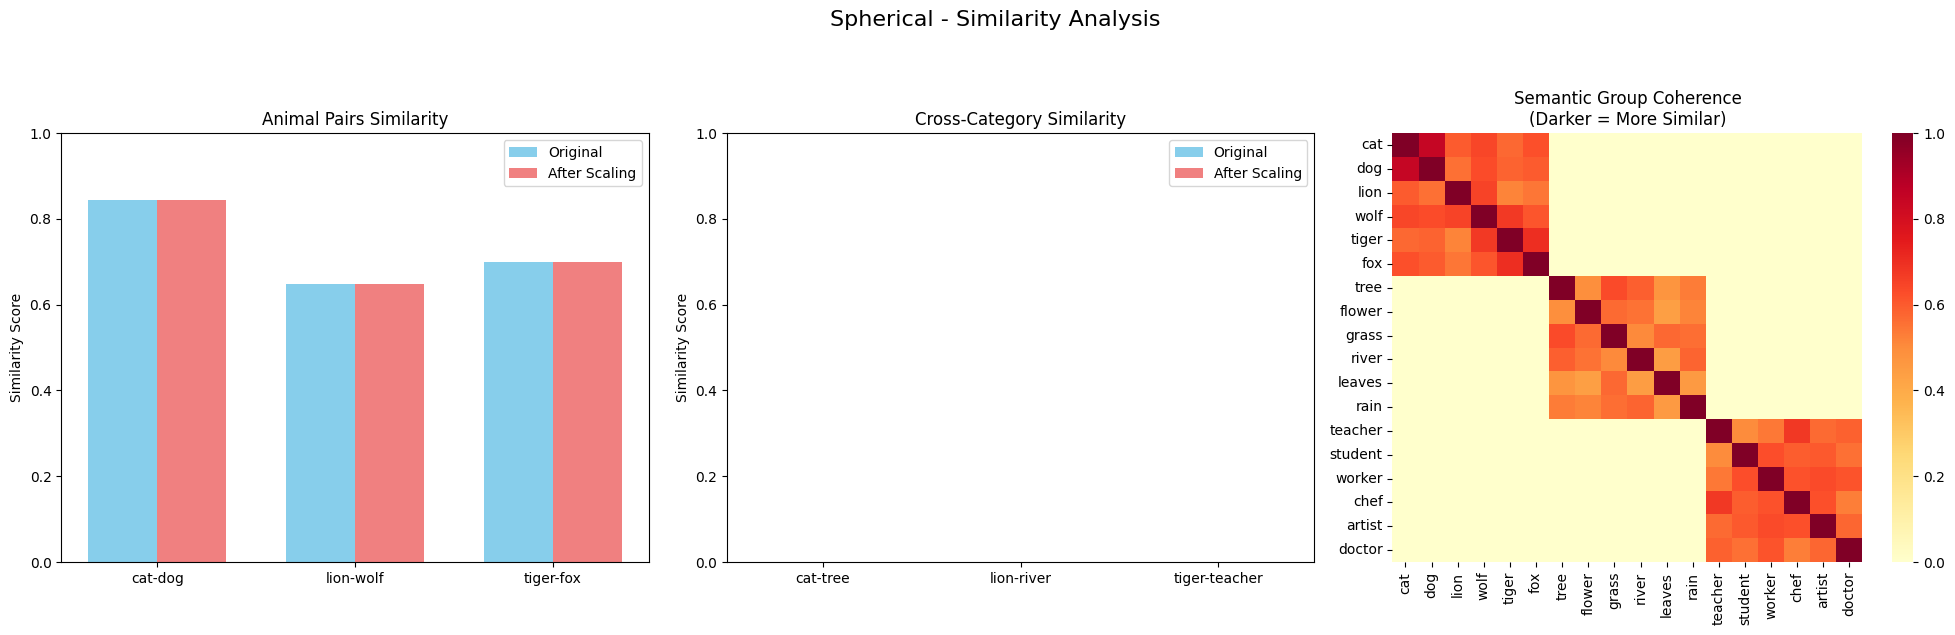


Spherical Key Metrics:
Average within-group similarity: 0.581
Average between-group similarity: -0.129
Semantic separation: 0.710
--------------------------------------------------


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_similarity_comparison(sentences, models_data):
    """
    Compare similarities across different models
    models_data: list of tuples (name, original_sim, scaled_sim)
    """
    for model_name, original_sim, scaled_sim in models_data:
        # Create a figure with three subplots
        fig = plt.figure(figsize=(20, 6))
        
        # 1. Animal Group Similarities
        ax1 = plt.subplot(131)
        
        # Prepare data for animal group comparisons
        animal_pairs = [
            ("cat-dog", (0, 1)),
            ("lion-wolf", (2, 3)),
            ("tiger-fox", (4, 5))
        ]
        
        # Get similarities
        pair_names = []
        orig_sims = []
        scaled_sims = []
        for name, (i, j) in animal_pairs:
            pair_names.append(name)
            orig_sims.append(original_sim[i][j])
            scaled_sims.append(scaled_sim[i][j])
        
        # Plot paired bars
        x = np.arange(len(pair_names))
        width = 0.35
        ax1.bar(x - width/2, orig_sims, width, label='Original', color='skyblue')
        ax1.bar(x + width/2, scaled_sims, width, label='After Scaling', color='lightcoral')
        
        ax1.set_ylabel('Similarity Score')
        ax1.set_title('Animal Pairs Similarity')
        ax1.set_xticks(x)
        ax1.set_xticklabels(pair_names)
        ax1.legend()
        ax1.set_ylim(0, 1)
        
        # 2. Cross-Category Similarities
        ax2 = plt.subplot(132)
        
        cross_pairs = [
            ("cat-tree", (0, 6)),
            ("lion-river", (2, 9)),
            ("tiger-teacher", (4, 12))
        ]
        
        # Get similarities
        cross_names = []
        cross_orig = []
        cross_scaled = []
        for name, (i, j) in cross_pairs:
            cross_names.append(name)
            cross_orig.append(original_sim[i][j])
            cross_scaled.append(scaled_sim[i][j])
        
        # Plot paired bars
        x = np.arange(len(cross_names))
        ax2.bar(x - width/2, cross_orig, width, label='Original', color='skyblue')
        ax2.bar(x + width/2, cross_scaled, width, label='After Scaling', color='lightcoral')
        
        ax2.set_ylabel('Similarity Score')
        ax2.set_title('Cross-Category Similarity')
        ax2.set_xticks(x)
        ax2.set_xticklabels(cross_names)
        ax2.legend()
        ax2.set_ylim(0, 1)
        
        # 3. Stability Analysis
        ax3 = plt.subplot(133)
        
        if model_name == "Spherical":
            # For spherical model, show semantic group coherence
            group_similarities = np.zeros_like(original_sim)
            for i in range(len(sentences)):
                for j in range(len(sentences)):
                    if groups[i] == groups[j]:
                        group_similarities[i,j] = 1
            
            sns.heatmap(original_sim * group_similarities,
                       ax=ax3,
                       cmap='YlOrRd',
                       vmin=0,
                       vmax=1,
                       xticklabels=[s.split()[1] for s in sentences],
                       yticklabels=[s.split()[1] for s in sentences])
            ax3.set_title('Semantic Group Coherence\n(Darker = More Similar)')
        else:
            # For other models, show stability
            similarity_changes = np.abs(scaled_sim - original_sim)
            sns.heatmap(similarity_changes,
                       ax=ax3,
                       cmap='YlOrRd',
                       vmin=0,
                       vmax=0.3,
                       xticklabels=[s.split()[1] for s in sentences],
                       yticklabels=[s.split()[1] for s in sentences])
            ax3.set_title('Similarity Changes\n(Darker = More Change)')
        
        plt.suptitle(f'{model_name} - Similarity Analysis', fontsize=16, y=1.05)
        plt.tight_layout()
        plt.show()
        
        # Print metrics
        print(f"\n{model_name} Key Metrics:")
        if model_name == "Spherical":
            # Calculate semantic coherence
            within_group_sim = []
            between_group_sim = []
            for i in range(len(sentences)):
                for j in range(i+1, len(sentences)):
                    sim = original_sim[i][j]
                    if groups[i] == groups[j]:
                        within_group_sim.append(sim)
                    else:
                        between_group_sim.append(sim)
            print(f"Average within-group similarity: {np.mean(within_group_sim):.3f}")
            print(f"Average between-group similarity: {np.mean(between_group_sim):.3f}")
            print(f"Semantic separation: {np.mean(within_group_sim) - np.mean(between_group_sim):.3f}")
        else:
            print(f"Average similarity change: {np.mean(np.abs(scaled_sim - original_sim)):.3f}")
            print(f"Max similarity change: {np.max(np.abs(scaled_sim - original_sim)):.3f}")
        print("-" * 50)

# Run visualization for all models
models_data = [
    ("No Regularization", no_reg_orig_sim, no_reg_scaled_sim),
    # ("L2 Regularization", l2_orig_sim, l2_scaled_sim),
    ("Spherical", spherical_sim, spherical_sim)  # Same sim twice since no scaling effect
]

visualize_similarity_comparison(sentences, models_data)